## Backprop history and importance: 

It was a common practice as late as 2016 to write your own backward pass instead of the autograd engine we use to call `loss.backward()`, which is why we will spend this lecture trying to get an intuitive sense of backprop by writing own own code to execute it. 

Essentially we will introduce many __intermediate variables__ to track the flow of gradients a bit like we did in autograd. 

We will also __revert__ to our simple model of neural network with only a __single hidden layer__. 

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
allchars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(allchars) }
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
words_shuffled = words[:]  # shallow copy -- to preserve across runs
random.shuffle(words_shuffled)
n1 = int(0.8*len(words_shuffled))
n2 = int(0.9*len(words_shuffled))

Xtr,  Ytr  = build_dataset(words_shuffled[:n1])     # 80%
Xdev, Ydev = build_dataset(words_shuffled[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words_shuffled[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Done with boilerplate init code, now to more concrete stuff. 

Lets define a comparing function to check whether analytically calculated gradients are close to those calculated by pytorch.

In [10]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {str(maxdiff):5s}')

Utility of `cmp`: 
- Line 1: compares all elements of dt and t.grad and compresses it to a single True or False boolean rather than a whole matrix
- Line 2: gives come wiggle room during comparison
- Line 3: captures the maximum difference bw the two values across the entire gradient matrix
- Line 4 is a simple print statement

Initializating many of these parameters in non-standard ways because sometimes initializating with e.g. all zeros could mask an incorrect
implementation of the backward pass.

In [11]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0 # non standard init
bnbias = torch.randn((1, n_hidden))*0.1 # non standard init

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [12]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [75]:
print(hprebn.shape, embcat.shape, W1.shape, b1.shape)
print(embcat.shape, emb.shape)
print(C.shape, emb.shape, Xb.shape)

torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])
torch.Size([32, 30]) torch.Size([32, 3, 10])
torch.Size([27, 10]) torch.Size([32, 3, 10]) torch.Size([32, 3])


In [13]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3569, grad_fn=<NegBackward0>)

In [66]:
t = torch.tensor([[1,-1.0], [9,7.0]])
t.mean(dim = 1, keepdim=True)

tensor([[0.],
        [8.]])

All cells above this one are just the basics being carried over. Now lets define: 

$\frac{\partial Loss}{\partial {logprobs}}$ and start from here as we go back in the chain to compute derivative of loss wrt each intermediate variable. 

At each step we uncomment each `cmp` call to check the proximity of our analytically calculated grad and pytorch calculated grad.

In [50]:
# c = a * b 
# dc/db = a
print(counts.shape, counts_sum_inv.shape) # broadcasting is implicit
print('--------------------')
print(logits.shape, h.shape, W2.shape, b2.shape)
print('--------------------')
print(hpreact.shape, bnraw.shape, bngain.shape)
print('--------------------')
print(bndiff2.shape)

torch.Size([32, 27]) torch.Size([32, 1])
--------------------
torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])
--------------------
torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
--------------------
torch.Size([32, 64])


One tip to deduce formulae of gradients correctly is to check the shape of the original variable; the shape of the grad will also be same, since loss is a scalar. 

i.e. __if__ shape of logprobs = $(30,40)$ shape of dlogprobs also will be $(30,40)$. 

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">Caution:</span><br>
1. for `probs = counts_sum_inv * counts`, there are __2 steps__: broadcasting counts_sum_inv and then multiplication, which is why in `dcounts_sum_inv` we sum the gradients along dim 1

2. At some places, a `+=` is used to _accumulate_ gradients if a variable is repeated during backpass. 

3. `A*B` is element-wise multiplication and and `A@B` is matrix multiplication. 

In [14]:
# Exercise 1: bacmp('logprobs', dlogprobs, logprobs)

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = 1/probs * dlogprobs # chain rule

dcounts = dprobs * counts_sum_inv # 1st contribution, rest comes from count_sum_inv definition!
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # this is tricky -- understand using shape analogy

dcounts_sum =   (-1/(counts_sum)**2) * dcounts_sum_inv

dcounts2 = torch.ones_like(counts) * dcounts_sum
dcounts += dcounts2 

dnorm_logits = dcounts * counts #exponential goes unscathed

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # similar to dcounts_sum_inv -- broadcasting takes place to beware

dh = dlogits @ W2.T  
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdims = True) # trick: dim(b2) = [27] => broadcasting happens across rows, so grad sum must be across rows. 

dhpreact = dh * (1-h**2)

dbnbias = dhpreact.sum(0, keepdims=True) # since dim(bnbias) = 1,64 => sum must be along rows (0) while broadcasting -- same as db2
dbngain = (dhpreact * bnraw).sum(0, keepdims = True) # from dimensional analysis
dbnraw = bngain * dhpreact

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdims = True)
dbndiff = dbnraw * bnvar_inv # will have to add another components from dbndiff2.grad

dbnvar = dbnvar_inv * (-0.5 * ((bnvar + 1e-5)**-1.5)) # simple derivative
dbndiff2 = dbnvar * torch.ones_like(bndiff2) * 1/(n-1) # decrypting broadcasting using math

dbndiff += 2*bndiff*dbndiff2 # add second component 

dbnmeani = -1* dbndiff.sum(0, keepdim=True)

dhprebn = dbndiff.clone()
dhprebn += dbnmeani * 1/n * torch.ones_like(hprebn) # since there were 2 components 

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim = True)

demb = dembcat.view(emb.shape[0], block_size, -1) #since this was just a dim transformation in forward pass too

# proceed based on intuition and dimensions of C, emb and Xb
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

print('---------GRAD comparison results--------------')
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

# backpropagating through exactly all of the variables manually
# as they are defined in the forward pass above, one by one




---------GRAD comparison results--------------
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0  
probs           | exact: True  | approximate: True  | maxdiff: 0.0  
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0  
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0  
counts          | exact: True  | approximate: True  | maxdiff: 0.0  
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0  
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0  
logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
h               | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
W2              | exact: False | approximate: True  | maxdiff: 1.30385160446167e-08
b2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
hpreact         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bngain          | exact: False | approximate: 

It does take some effort to trace it all the way back but matching dimensions of variables is really the trick. Understanding broadcasting, accumulation etc operations. 

### On Bessel's correction 

In the line: <br>
`bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)` <br>
whether to use $\frac{1}{n-1}$ or $\frac{1}{n}$ is a bit of a confusion in the [original batch norm paper](https://arxiv.org/abs/1502.03167) since they use one during training and other during testing which can, however minutely, give fudged results. Andrej prefers using 
$\frac{1}{n-1}$ uniformly. More debate can be found [here](https://math.oxford.emory.edu/site/math117/besselCorrection/)


## Exercise 2

Backprop through cross_entropy but all in one go to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.

In [15]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3568549156188965 diff: 4.76837158203125e-07


Similarly, now in computation of `dlogits` we will derive a mathematical relation to prevent calculation of derivatives of `[logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes]` to reach upto `dlogits`. 

__So the goal is:__ `dlogits = f(logits, Yb)` i.e. an attempt to calculate the loss analytically from the logits matrix.

Andrej's sense of the implementation: 

<img title="a title" alt="Alt text" src="images/backprop_logits.jpg" width = 60%>

We are using a simple division rule for calculating the derivatives. 

This definition of loss for a single examples can be __extended to a batch of examples__ and just has to be divided by 'n' (batch size) since its mean loss. 

In [50]:
dlogits_analytical = F.softmax(logits, 1) # use softmax directly 
dlogits_analytical[range(n), Yb] -= 1 # pi-1 for indices where i = yb
dlogits_analytical /= n

cmp('logits', dlogits_analytical, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


## Intuition on dlogits

Consider the `0th row` following of the following matrices:

1. `probs[0]` which is: $\approx$ `F.softmax(logits, 1)[0]`
2. `dlogits[0]*n` which is: the matrix after 2 steps of above cell. 

In [51]:
F.softmax(logits, 1)[0]

tensor([0.0660, 0.0886, 0.0187, 0.0501, 0.0194, 0.0883, 0.0275, 0.0347, 0.0175,
        0.0304, 0.0367, 0.0320, 0.0354, 0.0270, 0.0348, 0.0141, 0.0096, 0.0202,
        0.0176, 0.0553, 0.0535, 0.0215, 0.0228, 0.0671, 0.0635, 0.0261, 0.0215],
       grad_fn=<SelectBackward0>)

In [53]:
dlogits[0]*n

tensor([ 0.0660,  0.0886,  0.0187,  0.0501,  0.0194,  0.0883,  0.0275,  0.0347,
        -0.9825,  0.0304,  0.0367,  0.0320,  0.0354,  0.0270,  0.0348,  0.0141,
         0.0096,  0.0202,  0.0176,  0.0553,  0.0535,  0.0215,  0.0228,  0.0671,
         0.0635,  0.0261,  0.0215], grad_fn=<MulBackward0>)

The above 2 are same, except in the place of `Yb[0]`. 

In [59]:
print(dlogits[0].sum(),              # 0
      ( dlogits[0]*n)[Yb[0]] )

tensor(-6.9849e-09, grad_fn=<SumBackward0>) tensor(-0.9825, grad_fn=<SelectBackward0>)


What this means is that the gradient sums to zero along each row (for each datapoint). i.e. the gradient at `Yb[i]` tries to 'pull down' the other incorrect gradients by being large negative `-0.9825`, while other grads are small positive!

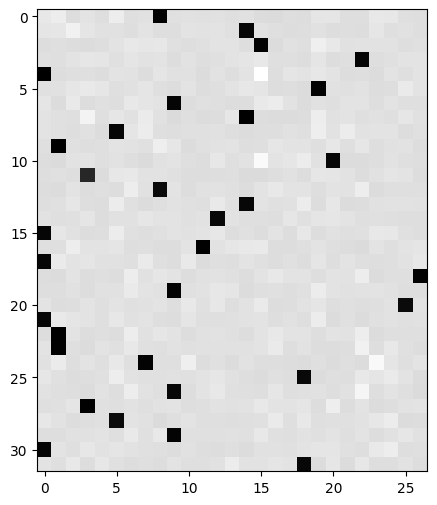

In [60]:
plt.figure(figsize=(6,6))
plt.imshow(dlogits.detach(), cmap='gray')

The dark squares with high magnitudes of grad correspond to `Yb[i]`, clearly. 

## Exercise 3

Writing analytical forward and backprop for batch normalization:

In [62]:
# Exercise 3: backprop through batchnorm but all in one go

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now: 
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [68]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()

# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)


dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


This above step requires lucidity at a crazy level to do analytically. Watch the original explanation from Karpathy [here](https://youtu.be/q8SA3rM6ckI?si=RYYjl8qvM1Z_fT89&t=5830) for best explanation. 

The derivation is _not trivial_, but still can be worked through with some peace of mind and patience. Maybe some other time. 

# Piecing it all together:

We essentially replace the loss.backward() with different the components for backprop written above and make it into a big coherent code. 

In [70]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8150
  10000/ 200000: 2.1582
  20000/ 200000: 2.3969
  30000/ 200000: 2.4801
  40000/ 200000: 2.0356
  50000/ 200000: 2.3749
  60000/ 200000: 2.3758
  70000/ 200000: 2.1325
  80000/ 200000: 2.2873
  90000/ 200000: 2.1990
 100000/ 200000: 2.0091
 110000/ 200000: 2.3595
 120000/ 200000: 2.0195
 130000/ 200000: 2.4874
 140000/ 200000: 2.3232
 150000/ 200000: 2.2071
 160000/ 200000: 1.9344
 170000/ 200000: 1.8035
 180000/ 200000: 1.8897
 190000/ 200000: 1.8330


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [71]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1025378704071045
val 2.1408493518829346


This can be reduced to 2.10 on val, but that is about it.

In [72]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mriah.
myah.
see.
madhanalorethruthadraege.
zered.
elin.
shi.
jenne.
elsen.
anareelynn.
hone.
mayshabergihiriel.
janie.
jennex.
terori.
brence.
ryyshunzels.
kayshaston.
azhil.
samyahsun.


__Résumé__: All we did was replace loss.backward() by a custom analytically derived backprop equation. So the output names, are still gibberish looking names. 

We may have to move to 
1. more advanced architectures Or
2. increase the context length 

To further improve the model performance, which we will explore in the subsequent lectures. 

<img title="a title" alt="Alt text" src="images/doge_meme.png" width=40%>